In [1]:
from ctypes import CFUNCTYPE, POINTER, c_char_p, c_void_p, cast, pointer

import matplotlib.pyplot as plt
import numpy as np
from lilv import (LV2_URID, Instance, LV2_Feature, LV2_URID_Map,
                  LV2_URID_Map_Handle, World)

In [2]:
URIDMap_fn_type = CFUNCTYPE(LV2_URID, LV2_URID_Map_Handle, c_char_p)
urids ={}

def do_map(handle:LV2_URID_Map_Handle, ptr:c_char_p):
    uri = str(ptr)
    if not uri in urids:
        urids[uri] = len(urids)
    return urids[uri]

def run_audio_plugin(uri, buffers=[], samplerate = 48000, input_index=0):
    world = World()
    world.load_all()
    plugin = world.get_all_plugins().get_by_uri(uri)

    URIDMapFeature = LV2_Feature()
    URIDMapFeature.URI = bytes("http://lv2plug.in/ns/ext/urid#map", "utf-8")

     
    uridMap = LV2_URID_Map()
    uridMap.map = URIDMap_fn_type(do_map)
    URIDMapFeature.data = cast(pointer(uridMap), c_void_p)

    features = [pointer(URIDMapFeature), cast(None, POINTER(LV2_Feature))]
    features = (POINTER(LV2_Feature) * len(features))(*features)

    instance = Instance(plugin, samplerate, features = features)
    instance.activate()
    for index, buffer in buffers.items():
      instance.connect_port(index, buffer)
    
    instance.run(buffers[input_index].size)
    instance.deactivate()

In [3]:
samplingrate, nsamples = 48000, 2048
buffers = {
    0: np.sin(440 * 2 * np.pi * np.arange(nsamples) / samplingrate),
    1: np.zeros(nsamples),
    2: np.zeros(nsamples),
    3: np.array([1.0]),
    4: np.array([1.5]),
}

In [4]:
run_audio_plugin("https://github.com/jrialland/lv2plugins/threedee", buffers)

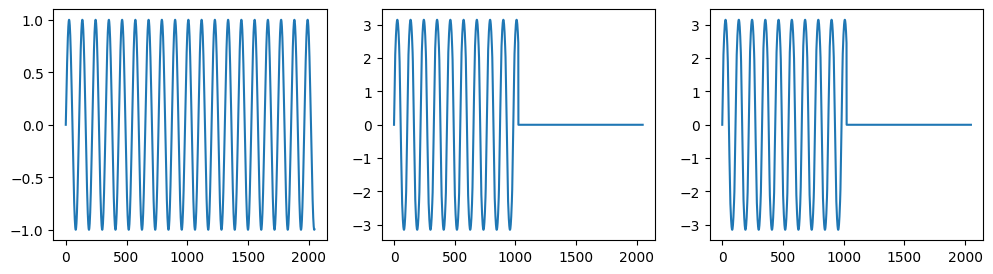

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
for i in range(3): axes[i].plot(buffers[i])